# Within-subject analysis


In [2]:
import glob
import re
from nilearn.glm.second_level import SecondLevelModel
import pandas as pd
import nibabel as nf

root = '/oak/stanford/groups/russpold/data/uh2/aim1'
activation_map_path = f'{root}/derivatives/output_surveyMedley_noderivs_rerun/surveyMedley_lev1_output/task_surveyMedley_rtmodel_rt_duration/contrast_estimates'
activation_maps = glob.glob(f'{activation_map_path}/*')

sub_ids = sorted(set([re.search('_sub_(.*)_rtmodel_rt_duration_stat_contrast.nii.gz', val).group(1) for val in activation_maps]))
# exclude the subjects who contribute to the most dropout in the group mask (this was determined earlier by Jeanette)
excluded_subject_ids = ['234', '445']
sub_ids = [sub for sub in sub_ids if sub not in excluded_subject_ids]

# Load events files
events_files = sorted(glob.glob(f'{root}/BIDS/sub-s*/ses-[0-9]/func/*surveyMedley*modified*.tsv'))

In [2]:
def get_sub_event_file(sub_id, events_files):
    for file in events_files:
        if sub_id in file:
            return file

In [20]:
for sub in sub_ids:
    # First, make the design matrix
    design_matrix = pd.DataFrame()
    behavioral_measures = []
    sub_event_file = get_sub_event_file(sub, events_files)
    sub_bold_files = []
    df = pd.read_csv(sub_event_file, sep='\t')
    # create behavioral measures column, making sure the responses are in order
    for i in range(40):
        str_question_num = 'Q' + str(i + 1).zfill(2)
        response = df.loc[df['trial_type'] == str_question_num, 'coded_response']
        behavior = response.values[0]
        if not pd.isna(behavior):
            question_bold_file = f'{activation_map_path}/task_surveyMedley_contrast_{str_question_num}_v_baseline_sub_{sub}_rtmodel_rt_duration_stat_contrast.nii.gz'
            if question_bold_file in activation_maps:
                sub_bold_files.append(question_bold_file)
                behavioral_measures.append(behavior)
                
    design_matrix["behavioral_measures"] = behavioral_measures
    design_matrix["intercept"] = 1

    model = SecondLevelModel(n_jobs=2)
    model.fit(sub_bold_files, design_matrix=design_matrix)
    contrast_map = model.compute_contrast(second_level_contrast='behavioral_measures', output_type='effect_size')
    nf.save(contrast_map, f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/behavioral_measures_effect_size_sub_{sub}.nii.gz')

# Group level analysis

In [1]:
from randomise_prep import setup_randomise_tfce
from nilearn import masking

In [10]:
# outlier criteria: > 8% voxels above +/- 3SD above subject-specific mean
outlier_subject_ids = ['061', '512', '605', '627']
sub_ids = [sub for sub in sub_ids if sub not in outlier_subject_ids]

# Make group mask
subject_masks = glob.glob(f'{root}/derivatives/fmriprep/sub-s*/ses-['
                        f'0-9]/func/*surveyMedley*space-MNI152NLin2009cAsym*mask*.nii.gz')
subject_masks = [mask for mask in subject_masks if any(id in mask for id in sub_ids)]
group_mask = masking.intersect_masks(subject_masks, threshold=1)
nf.save(group_mask, f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/group_mask_brain_behavior_within_subject.nii.gz')

contrast_estimates = glob.glob(f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/behavioral_measures_effect_size*')
contrast_estimates = [file for file in contrast_estimates if any(sub_id in file for sub_id in sub_ids)]

script_path = setup_randomise_tfce(
    input_files=contrast_estimates,
    group_mask='/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/group_mask_brain_behavior_within_subject.nii.gz',
    output_directory="/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/output_twosided_onesample_t_test",
    analysis_type="onesample_2sided",
    num_perm=5000
)

print(f'Generated script: {script_path}')

Concatenating input files...
Created 4D file: /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/output_twosided_onesample_t_test/input_data4d.nii.gz
Generated script: /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/output_twosided_onesample_t_test/randomise_call.sh


Run the generated randomise_call.sh script using the submit_randomise.sh file in 'analyses/within_subject_brain_behavior_analysis' to get the uncorrected t-stat map and F-stat p-value map before plotting them.

# Plot figures

In [1]:
from nilearn import plotting

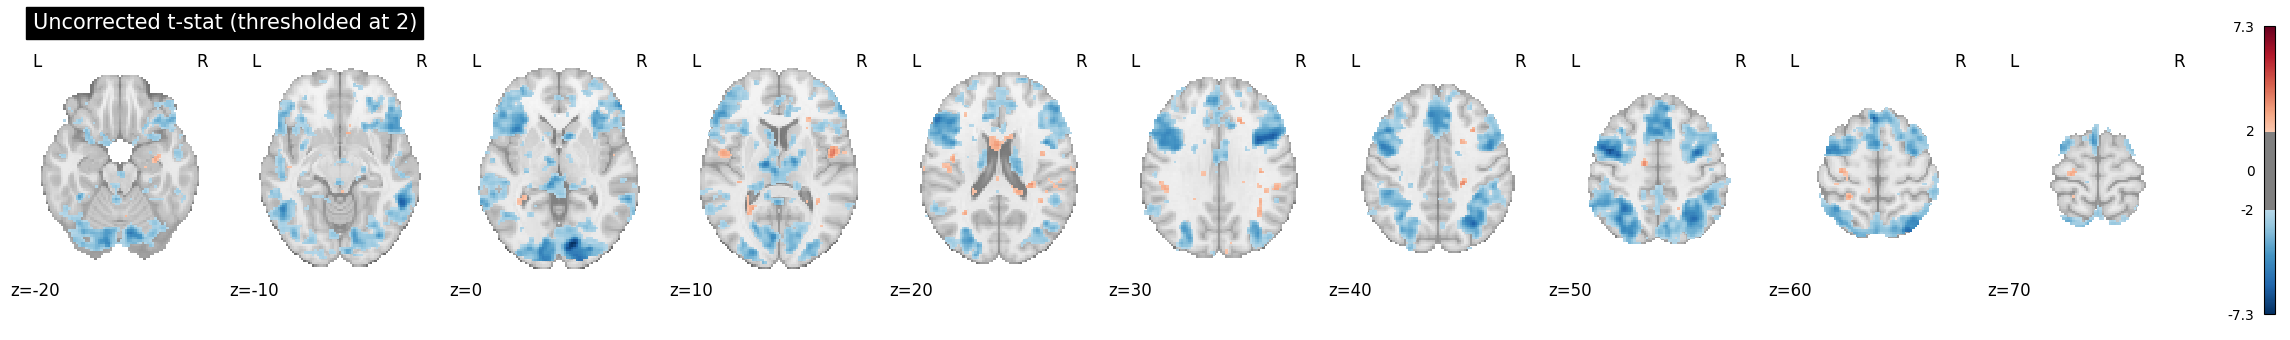

In [3]:
z_slices = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70]
output_path = f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/output_twosided_onesample_t_test'

# Plot uncorrected t-stat map
tstat_map = nf.load(f'{output_path}/uncorrected_tstat1.nii.gz')
plotting.plot_stat_map(
            tstat_map,
            display_mode='z',
            cut_coords=z_slices,
            threshold=2.0, 
            colorbar=True,
            title=f'Uncorrected t-stat (thresholded at 2)'
        )
plotting.show()

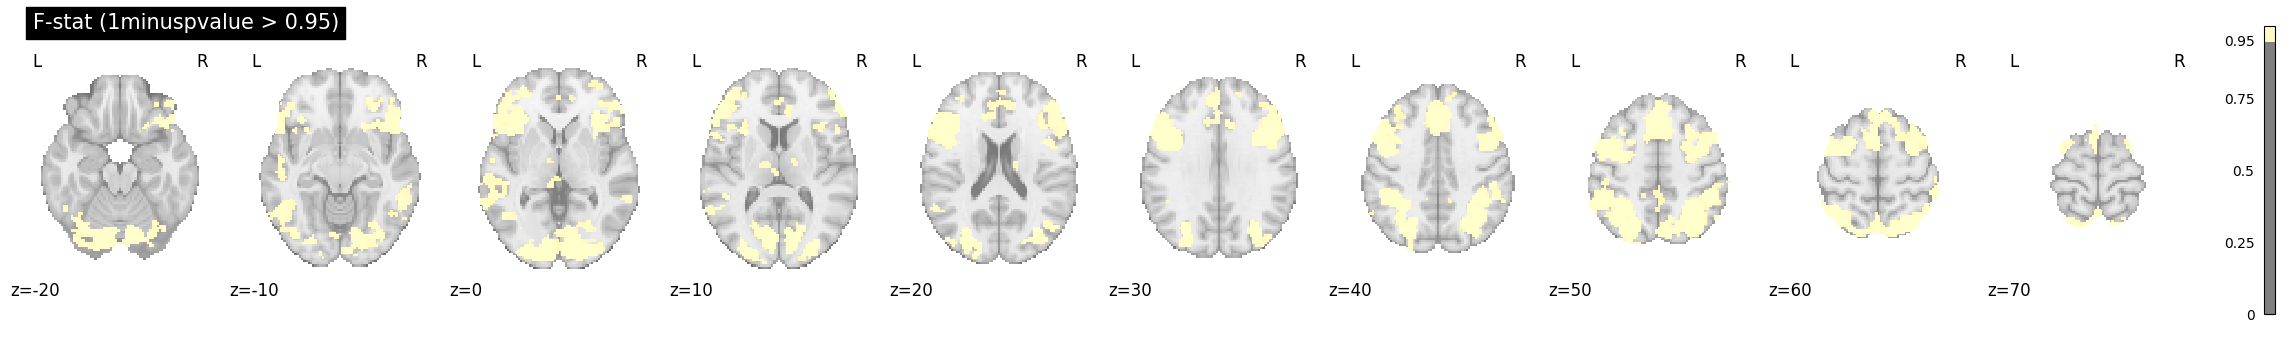

In [4]:
# Plot F-stat p-value map
fstat_pvalue_map = nf.load(f'{output_path}/onesample_2sided_tfce_corrp_fstat1.nii.gz')
plotting.plot_stat_map(
            fstat_pvalue_map,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            cmap='YlOrRd_r', 
            vmin=0, 
            vmax=1,
            threshold=0.95, 
            title=f'F-stat (1minuspvalue > 0.95)'
        )
plotting.show()